# RF MODEL

## Feature Selection/Preperation

In [2]:
import pandas as pd

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Data Exploration Listings/cleaned_dataset.xlsx'
#read data, and quickly check if it is correctly read in
dataframe1= pd.read_excel(file_path)

In [3]:
# Creating a copy of the dataset to work with
data_copy = dataframe1.copy()
#looking into which columns currently still have empty values
columns_with_nan = data_copy.columns[data_copy.isna().any()].tolist()
# Print the columns
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'days_since_first_review', 'days_since_first_first_review', 'days_since_last_review', 'days_since_last_last_review']


In [4]:
columns_to_drop = ["id", "host_id", "days_since_host_host","host_since"]
data_copy = data_copy.drop(columns_to_drop, axis=1)

In [5]:
# Display columns with datetime type
datetime_columns = data_copy.select_dtypes(include=['datetime64[ns]']).columns
print("Datetime Columns:", datetime_columns.tolist())

Datetime Columns: ['first_review', 'last_review']


In [6]:
#to many missing values in these columns, thus removing them
columns_to_drop = ['first_review', 'last_review','days_since_first_review', 'days_since_first_first_review', 'days_since_last_review', 
                   'days_since_last_last_review']

#filling in 0 in the fields where nothing is filled in
columns_to_fill = ['review_scores_rating', 'review_scores_accuracy', 
                   'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                   'review_scores_location', 'review_scores_value', 'reviews_per_month']

# Fill NaN values with 0 in the specified columns
for column in columns_to_fill:
    data_copy[column] = data_copy[column].fillna(0)

data_copy_clean = data_copy.drop(columns_to_drop, axis=1)

#looking into which columns currently still have empty values
columns_with_nan = data_copy_clean.columns[data_copy_clean.isna().any()].tolist()
# Print the columns
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [7]:
#looking which columns are strings
string_columns = [col for col in data_copy_clean.columns if data_copy_clean[col].dtype == 'object' or isinstance(data_copy_clean[col].dtype, pd.StringDtype)]
print(string_columns)

#looking which columns are categories
category_columns = [col for col in data_copy_clean.columns if data_copy_clean[col].dtype == 'category' or isinstance(data_copy_clean[col].dtype, pd.CategoricalDtype)]
print(category_columns)

['host_response_time', 'host_response_rate', 'neighbourhood', 'property_type', 'room_type']
[]


In [8]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Splitting the columns up in one-hot and label encoding
categorical_columns_one_hot = ['neighbourhood', 'property_type', 'room_type']  # For one-hot encoding
categorical_columns_label = ['host_response_time', 'host_response_rate']  # For label encoding

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(data_copy_clean[categorical_columns_one_hot])

# Manually create feature names for the one-hot encoded columns
one_hot_feature_names = []
for i, column in enumerate(categorical_columns_one_hot):
    categories = one_hot_encoder.categories_[i]
    one_hot_feature_names.extend([f"{column}_{category}" for category in categories])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names, index=data_copy_clean.index)

# Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns_label:
    data_copy_clean[col] = label_encoder.fit_transform(data_copy_clean[col])

# Concatenate the one-hot encoded columns back to the original dataframe
data_copy_clean = pd.concat([data_copy_clean, one_hot_encoded_df], axis=1)

# Drop the original string columns
data_copy_clean.drop(categorical_columns_one_hot, axis=1, inplace=True)

C:\Users\anton\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
data_copy_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56145 entries, 0 to 56144
Columns: 161 entries, host_response_time to room_type_Shared room
dtypes: bool(99), float64(39), int32(2), int64(21)
memory usage: 31.4 MB


In [10]:
# Convert columns with exclusively 0s and 1s to boolean
for col in data_copy_clean.columns:
    unique_values = data_copy_clean[col].unique()
    if set(unique_values).issubset({0, 1}):
        data_copy_clean[col] = data_copy_clean[col].astype(bool)

In [12]:
#cap all the outliers (the ones that are below 0.05 or above 0.95 percentile) to 0.05 percentile and 0.95 percentile
from scipy.stats.mstats import winsorize
import numpy as np
for col in data_copy_clean.select_dtypes(include=np.number).columns:
    data_copy_clean[col] = winsorize(data_copy_clean[col], limits=[0.05, 0.05])

In [13]:
data_copy_clean.to_excel('data_RF.xlsx', index=False)

## 1. RF without further selection

In [14]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

X = data_copy_clean.drop("price", axis=1)
y = data_copy_clean['price']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)

#looking at MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error:, {mse:.4f}")

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictor variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

Mean Squared Error:, 2648.0818
R-squared: 0.7306
Adjusted R-squared: 0.7280


## 2. RF with feature importance score (0.01 threshold)

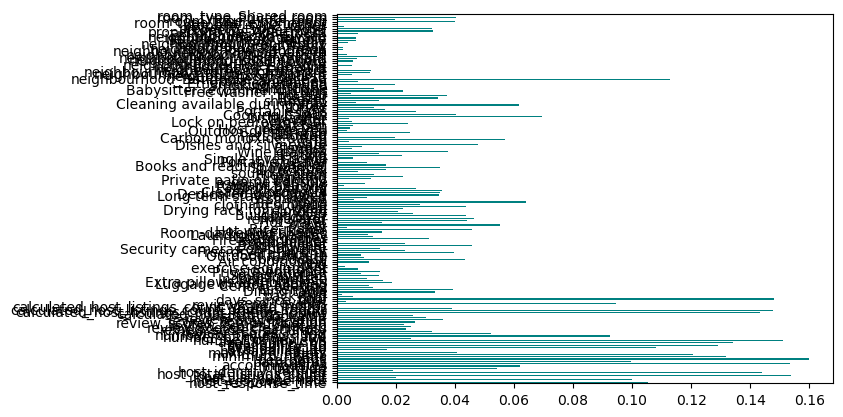

In [15]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline
!pip install --upgrade joblib

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

X = data_copy_clean.drop("price",axis=1)
Y = data_copy_clean['price']

importances = mutual_info_classif(X,Y)
feat_importances = pd.Series(importances, X.columns)
feat_importances.plot(kind='barh', color= "teal")
plt.show()

In [16]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

X = data_copy_clean.drop("price", axis=1)
y = data_copy_clean['price']

# Calculate feature importances
importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns)

# Set a threshold for feature importance (this is arbitrary and can be adjusted)
threshold = 0.01  # Example threshold

# Select features above the importance threshold
selected_features = feat_importances[feat_importances > threshold].index

# Rebuild the feature set with only selected features
X_selected = X[selected_features]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)

#looking at MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictor variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", adjusted_r2)

Mean Squared Error: 2677.9551375144333
R-squared: 0.7275191716230661
Adjusted R-squared: 0.7257934759901596


## 3. RF with Backward Feature Selection

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load your data
X = data_copy_clean.drop('price', axis=1)
y = data_copy_clean['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a simpler model for feature selection
selection_model = RandomForestRegressor(random_state=42)

# Initialize variables for tracking the best R-squared and corresponding feature set
best_r_squared = 0
best_features_set = X_train.columns.tolist()

# Start Backward Feature Elimination with a simpler model
for _ in range(len(X_train.columns) - 1):
    selection_model.fit(X_train, y_train)
    predictions = selection_model.predict(X_test)
    current_r_squared = r2_score(y_test, predictions)

    if current_r_squared > best_r_squared:
        best_r_squared = current_r_squared
        best_features_set = X_train.columns.tolist()
    
    # Remove the least important feature
    importances = selection_model.feature_importances_
    least_important = np.argmin(importances)
    X_train = X_train.drop(X_train.columns[least_important], axis=1)
    X_test = X_test.drop(X_test.columns[least_important], axis=1)

# Train final model with Random Forest using the best feature set
final_model = RandomForestRegressor(random_state=42, n_jobs=-1)
X_train_best = X_train
X_test_best = X_test
final_model.fit(X_train_best, y_train)

# Evaluate the final model
final_predictions = final_model.predict(X_test_best)
final_performance = mean_squared_error(y_test, final_predictions)
final_r_squared = r2_score(y_test, final_predictions)
adjusted_r2 = 1 - (1 - final_r_squared) * (len(y_test) - 1) / (len(y_test) - X_train_best.shape[1] - 1)

print(f"Final performance: MSE: {final_performance:.4f}, R-squared: {final_r_squared:.4f}, Adjusted R-squared: {adjusted_r2:.4f}")
print("Best selected features:", best_features_set)

## 4. RF with selection based on correlation and VIF

In [19]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming data_copy_clean is your DataFrame
# Ensure that only numeric data is used for VIF calculation
numeric_data = data_copy_clean.select_dtypes(include=[np.number])

# Adding a constant column for intercept
numeric_data_with_constant = add_constant(numeric_data)

# Sampling 40% of the data for performance reasons
sampled_data = numeric_data_with_constant.sample(frac=0.4, random_state=42)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = sampled_data.columns
vif_data["VIF"] = [variance_inflation_factor(sampled_data.values, i) for i in range(sampled_data.shape[1])]

print(vif_data)

                                         Feature           VIF
0                                          const  8.170128e+06
1                             host_response_time  3.824581e+00
2                             host_response_rate  3.742092e+00
3                            host_listings_count  3.841072e+01
4                      host_total_listings_count  1.699651e+01
5                                       latitude  1.030710e+00
6                                      longitude  1.082767e+00
7                                   accommodates  3.760989e+00
8                                      bathrooms  1.521880e+00
9                                       bedrooms  2.459357e+00
10                                          beds  3.435326e+00
11                                         price  2.052343e+00
12                                minimum_nights  2.063262e+00
13                                maximum_nights  1.384536e+00
14                               availability_30  1.122

C:\Users\anton\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [20]:
# Filter and display features with VIF greater than 5
high_vif_features = vif_data[vif_data["VIF"] > 5]
print("Features with VIF greater than 5:\n", high_vif_features)

Features with VIF greater than 5:
                                         Feature           VIF
0                                         const  8.170128e+06
3                           host_listings_count  3.841072e+01
4                     host_total_listings_count  1.699651e+01
14                              availability_30  1.122139e+01
15                              availability_60  5.137418e+01
16                              availability_90  3.405559e+01
21                         review_scores_rating  1.056763e+02
22                       review_scores_accuracy  9.063395e+01
23                    review_scores_cleanliness  4.230328e+01
24                        review_scores_checkin  7.657172e+01
25                  review_scores_communication  8.800196e+01
26                       review_scores_location  4.742106e+01
27                          review_scores_value  6.650516e+01
28               calculated_host_listings_count  7.079617e+01
29  calculated_host_listings_count_

In [22]:
columns_to_remove = ['host_listings_count', 'availability_30', 'availability_60', 'review_scores_accuracy', 
                     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes']

# Dropping the specified columns from the dataset
data = data_copy_clean.drop(columns=columns_to_remove)

# Your dataset now has reduced multicollinearity

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'target' is your target variable and it's in the original 'data' DataFrame
X = data.drop('price',axis=1)
y = data['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_train.shape[1] - 1)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"R-squared adjusted: {adjusted_r2:.4f}")

Mean Squared Error: 2644.3581
R-squared: 0.7309
R-squared adjusted: 0.7285


In [24]:
import pandas as pd

# Load your data
data = data_copy_clean.copy()

# Calculate the correlation matrix
corr_matrix = data.corr()

# Set a threshold for high correlation (for example, 0.8)
high_corr_threshold = 0.8

# Identify features highly correlated with the target variable
target_variable = 'price'  # Replace with your actual target variable name
high_corr_with_target = corr_matrix[target_variable].abs().sort_values(ascending=False)

# Selecting features with high correlation to the target
selected_features = high_corr_with_target[high_corr_with_target > high_corr_threshold].index.tolist()
selected_features.remove(target_variable)  # Remove the target variable itself from the list

# Identify and remove redundant features
redundant_features = set()
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        if abs(corr_matrix.loc[selected_features[i], selected_features[j]]) > high_corr_threshold:
            # Add one of the highly correlated features to the redundant set
            redundant_features.add(selected_features[j])

# Remove redundant features from selected features
final_features = [feature for feature in selected_features if feature not in redundant_features]

# Now, final_features contains the features you want to keep
print("Selected features:", final_features)

Selected features: []


In [26]:
data = data_copy_clean.copy()
# Assuming data_copy_clean is your DataFrame and 'target_variable' is your target column name
target_variable = 'price'  # Replace with your actual target column name

# Calculate the correlation matrix
corr_matrix = data.corr()

# Extract the correlations of all features with the target variable
target_correlations = corr_matrix[target_variable].sort_values(ascending=False)

# Display the correlations
print("Correlations with the target variable:\n", target_correlations)

Correlations with the target variable:
 price                                          1.000000
accommodates                                   0.515159
bedrooms                                       0.513329
beds                                           0.482900
bathrooms                                      0.468831
                                                 ...   
longitude                                     -0.187414
property_type_Apartment                       -0.195402
host_response_rate                            -0.247284
minimum_nights                                -0.258921
calculated_host_listings_count_shared_rooms         NaN
Name: price, Length: 161, dtype: float64


In [27]:
# Set a threshold for identifying high correlations (e.g., 0.8 or 0.9)
high_corr_threshold = 0.8


# Calculate the correlation matrix
corr_matrix = data.corr()

# Find pairs of highly correlated features
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Print out the highly correlated pairs
for pair in high_corr_pairs:
    print(f"Feature pair: {pair[0]}, {pair[1]} - Correlation: {pair[2]:.2f}")

Feature pair: host_response_time, host_response_rate - Correlation: -0.82
Feature pair: host_listings_count, host_total_listings_count - Correlation: 0.97
Feature pair: host_listings_count, calculated_host_listings_count - Correlation: 0.98
Feature pair: host_listings_count, calculated_host_listings_count_entire_homes - Correlation: 0.95
Feature pair: host_total_listings_count, calculated_host_listings_count - Correlation: 0.95
Feature pair: host_total_listings_count, calculated_host_listings_count_entire_homes - Correlation: 0.93
Feature pair: accommodates, beds - Correlation: 0.83
Feature pair: availability_30, availability_60 - Correlation: 0.95
Feature pair: availability_30, availability_90 - Correlation: 0.91
Feature pair: availability_60, availability_90 - Correlation: 0.98
Feature pair: number_of_reviews_ltm, reviews_per_month - Correlation: 0.81
Feature pair: review_scores_rating, review_scores_accuracy - Correlation: 0.99
Feature pair: review_scores_rating, review_scores_clean

In [28]:
data = data_copy_clean.copy()
columns_to_remove = ['host_listings_count', 'availability_30', 'availability_60', 'review_scores_accuracy', 
                     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes'
                    ,'number_of_reviews_ltm','calculated_host_listings_count','Cooking basics','beds' ]

# Dropping the specified columns from the dataset
data = data.drop(columns=columns_to_remove)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a new DataFrame with only the selected features
X = data.drop('price',axis=1)
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_train.shape[1] - 1)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"R-squared adjusted: {adjusted_r2:.4f}")

Mean Squared Error: 2652.4423
R-squared: 0.7301
R-squared adjusted: 0.7278
